# Figure 17, Plot of overall Froude number vs dimensionless amplitude

Start by loading some boiler plate: matplotlib, numpy, scipy, json, functools, and a convenience class.

In [21]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import UnivariateSpline
import json
from functools import partial
class Foo: pass

And some more specialized dependencies:
 1. ``Slict`` provides a convenient slice-able dictionary interface
 2. ``Chest`` is an out-of-core dictionary that we'll hook directly to a globus remote using...
 3. ``glopen`` is an open-like context manager for remote globus files

In [2]:
from chest import Chest
from slict import CachedSlict
from glopen import glopen, glopen_many

Configuration for this figure.

In [3]:
config = Foo()
config.names = [
    "Wilk/Wilk_kmin_2.5/Wilk_kmin_2.5", 
    "Wilk/Wilk_kmin_3.5/Wilk_kmin_3.5",
    "Wilk/Wilk_kmin_4.5/Wilk_kmin_4.5"]
#config.arch_end = "maxhutch#alpha-admin/~/pub/"
config.arch_end = "alcf#dtn_mira/projects/alpha-nek/"

Open a chest located on a remote globus endpoint and load a remote json configuration file.

In [4]:
cs = []
for name in config.names:
    cs.append(Chest(path      = "{:s}-results".format(name),
                open      = partial(glopen,      endpoint=config.arch_end),
                open_many = partial(glopen_many, endpoint=config.arch_end))
              )
scs = [CachedSlict(c) for c in cs]

ps = []
for name in config.names:
    with glopen(
                "{:s}.json".format(name), mode='r',
                endpoint = config.arch_end,
                ) as f:
        ps.append(json.load(f))

We want to plot the spike depth, which is the 'H' field in the chest.
Chests can prefetch lists of keys more quickly than individual ones, so we'll prefetch the keys we want.

In [5]:
for c,sc in zip(cs, scs):
    c.prefetch(sc[:,'H'].full_keys())

Use a spline to compute the derivative of 'H' vs time: the Froude number.

In [39]:
spls = []
for sc in scs:
    spls.append(UnivariateSpline(sc[:,'H'].keys(),
                                 sc[:,'H'].values(),
                                 k = 5,
                                 s = 0.00001))
#    spls.append(InterpolatedUnivariateSpline(sc[:,'H'].keys(),
#                                             sc[:,'H'].values(),
#                                             k=5))
Frs = [spl.derivative() for spl in spls]
Tss = [np.linspace(sc[:,'H'].keys()[0], sc[:,'H'].keys()[-1], 1000) for sc in scs]

Plot the Froude number, non-dimensionalized by the theoretical dependence on Atwood, acceleration, and wave number, vs the spike depth, normalized by wave-length.

The dotted line is the theoretical prediction of Goncharaov.  The solid black line is the farthest that Wilkinson and Jacobs were able to get.

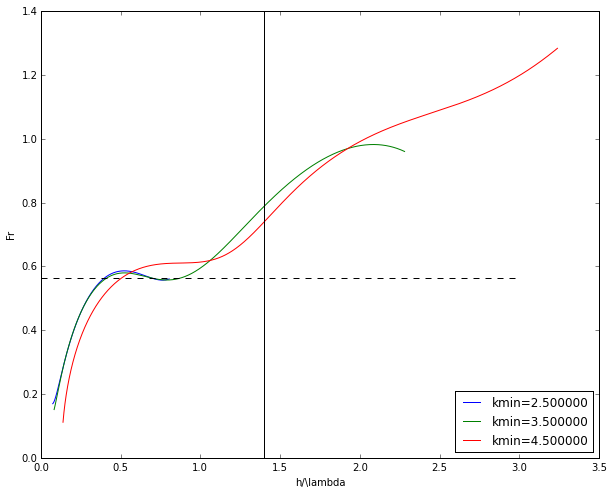

In [40]:
fig, axs = plt.subplots(1,1)

for p, spl, Fr, T in zip(ps, spls, Frs, Tss):
    axs.plot(
        -spl(T) * p["kmin"], 
        -Fr(T)/ np.sqrt(p["atwood"]*p["g"] / p["kmin"]),
        label="kmin={:f}".format(p["kmin"]));
axs.plot([0,3], [np.sqrt(1/np.pi), np.sqrt(1/np.pi)], 'k--')
axs.axvline(x=1.4, color='k');
axs.set_ylabel('Fr')
axs.set_xlabel('h/\lambda');
axs.legend(loc=4);
plt.savefig('Figure1.eps')

In [8]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py 
%load_ext version_information 
%version_information numpy, matplotlib, slict, chest, glopen, globussh

Installed version_information.py. To use it, type:
  %load_ext version_information


Software versions
Python 3.4.3 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 3.0.0
OS Linux 3.2.0 4 amd64 x86_64 with debian 7.8
numpy 1.9.2
matplotlib 1.4.3
slict 0.2.5
chest 0.2.1
glopen 0.0.11
globussh 0.1.0
Tue Jun 30 06:33:05 2015 CDT